In [226]:
# Import key libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cp

In [227]:
# List of ETFs that are to represent their respective asset classes 

tickers = ["SPY", # U.S. Large-Cap Equities
           "IJH", # U.S. Mid Cap
           "IWM", # U.S. Small Cap
           "EFA", # International Developed Markets
           "EEM", # Emerging Markets
           "AGG", # U.S. Aggregate Bonds
           "VNQ", # Real Estate 
           "DBC", # Commodities
           "GLD", # Gold 
           "BTC-USD" # Bitcoin
           ] 


In [228]:
# Establish start and end date for pulling price data

end_date = datetime.today()
start_date = end_date - timedelta(days=10 * 365)

In [229]:
# Pull Adjusted Close data for the defined list of tickers over the specified time period

adj_close_df = yf.download(tickers=tickers,
                           start=start_date,
                           end=end_date,
                           auto_adjust=False
                           )["Adj Close"]

[*********************100%***********************]  10 of 10 completed


In [230]:
# Review the number of rows of data for the different assets.

adj_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3651 entries, 2015-11-23 to 2025-11-20
Freq: D
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AGG      2514 non-null   float64
 1   BTC-USD  3650 non-null   float64
 2   DBC      2514 non-null   float64
 3   EEM      2514 non-null   float64
 4   EFA      2514 non-null   float64
 5   GLD      2514 non-null   float64
 6   IJH      2514 non-null   float64
 7   IWM      2514 non-null   float64
 8   SPY      2514 non-null   float64
 9   VNQ      2514 non-null   float64
dtypes: float64(10)
memory usage: 313.8 KB


In [231]:
# Drop any row that has a null value

adj_close_cleaned_df = adj_close_df.dropna(how='any')

In [232]:
# Review the number of rows after dropping rows with null values. 
# A lot of bitcoin data was dropped because bitcoin trades 7 days a week including the weekends. 

adj_close_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-11-23 to 2025-11-19
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AGG      2513 non-null   float64
 1   BTC-USD  2513 non-null   float64
 2   DBC      2513 non-null   float64
 3   EEM      2513 non-null   float64
 4   EFA      2513 non-null   float64
 5   GLD      2513 non-null   float64
 6   IJH      2513 non-null   float64
 7   IWM      2513 non-null   float64
 8   SPY      2513 non-null   float64
 9   VNQ      2513 non-null   float64
dtypes: float64(10)
memory usage: 216.0 KB


In [233]:
# Calculating the daily log returns for each asset. 
# Log returns are more used for longer time periods because stocks tend to drift up and stocks cannot go under 0.

log_returns = np.log(adj_close_cleaned_df / adj_close_cleaned_df.shift(1)).dropna()

In [234]:
log_returns.head()

Ticker,AGG,BTC-USD,DBC,EEM,EFA,GLD,IJH,IWM,SPY,VNQ
Date,,,,,,,,,,
2015-11-24,0.000920,-0.009330,0.015967,0.005161,0.000165,0.006628,0.006736,0.007299,0.001338,-0.005304
2015-11-25,0.000459,0.025177,-0.001378,-0.007751,0.002309,-0.004674,0.003351,0.007750,-0.000143,0.004044
2015-11-27,-0.000276,0.087009,-0.015289,-0.022145,0.000165,-0.011880,0.002932,0.003769,0.001146,0.008665
2015-11-30,0.000368,0.052446,-0.006322,0.001472,-0.000824,0.006595,-0.005050,-0.004357,-0.004160,-0.007404
2015-12-01,0.003498,-0.040105,0.011213,0.007620,0.010497,0.003526,0.008041,0.006611,0.009490,0.013761


In [235]:
# calculate the mean daily log returns of each asset class

log_returns_mean = log_returns.mean()

In [236]:
# typically 252 trading days in a year

annualized_mean_return = log_returns_mean * 252

In [237]:
# This is our expected return vector

annualized_mean_return

Ticker
AGG        0.019116
BTC-USD    0.566391
DBC        0.060831
EEM        0.066203
EFA        0.071647
GLD        0.130344
IJH        0.093500
IWM        0.082059
SPY        0.132616
VNQ        0.051232
dtype: float64

In [238]:
cov_daily = log_returns.cov()

In [239]:
# Covariance Matrix of all the Assets

cov_daily

Ticker,AGG,BTC-USD,DBC,EEM,EFA,GLD,IJH,IWM,SPY,VNQ
Ticker,,,,,,,,,,
AGG,1.151195e-05,0.000015,-1.231968e-07,0.000006,0.000006,0.000011,0.000006,0.000006,0.000004,0.000012
BTC-USD,1.461658e-05,0.001794,4.365174e-05,0.000115,0.000110,0.000039,0.000135,0.000160,0.000119,0.000102
DBC,-1.231968e-07,0.000044,1.244040e-04,0.000057,0.000047,0.000027,0.000054,0.000057,0.000044,0.000036
EEM,5.623015e-06,0.000115,5.696657e-05,0.000167,0.000118,0.000021,0.000125,0.000132,0.000111,0.000096
EFA,6.057515e-06,0.000110,4.662795e-05,0.000118,0.000120,0.000015,0.000122,0.000127,0.000106,0.000098
GLD,1.088989e-05,0.000039,2.707477e-05,0.000021,0.000015,0.000087,0.000006,0.000007,0.000005,0.000016
IJH,5.500967e-06,0.000135,5.377466e-05,0.000125,0.000122,0.000006,0.000181,0.000189,0.000139,0.000139
IWM,6.242199e-06,0.000160,5.705502e-05,0.000132,0.000127,0.000007,0.000189,0.000212,0.000144,0.000141
SPY,4.411479e-06,0.000119,4.441851e-05,0.000111,0.000106,0.000005,0.000139,0.000144,0.000130,0.000111


In [240]:
# Annualize daily covariances

cov_annual = cov_daily * 252

In [241]:
cov_annual

Ticker,AGG,BTC-USD,DBC,EEM,EFA,GLD,IJH,IWM,SPY,VNQ
Ticker,,,,,,,,,,
AGG,0.002901,0.003683,-0.000031,0.001417,0.001526,0.002744,0.001386,0.001573,0.001112,0.003119
BTC-USD,0.003683,0.452007,0.011000,0.028883,0.027805,0.009846,0.033910,0.040263,0.030006,0.025692
DBC,-0.000031,0.011000,0.031350,0.014356,0.011750,0.006823,0.013551,0.014378,0.011193,0.008990
EEM,0.001417,0.028883,0.014356,0.042023,0.029651,0.005371,0.031570,0.033142,0.027957,0.024115
EFA,0.001526,0.027805,0.011750,0.029651,0.030215,0.003804,0.030745,0.031944,0.026737,0.024693
GLD,0.002744,0.009846,0.006823,0.005371,0.003804,0.021868,0.001391,0.001810,0.001357,0.004069
IJH,0.001386,0.033910,0.013551,0.031570,0.030745,0.001391,0.045506,0.047684,0.034957,0.035132
IWM,0.001573,0.040263,0.014378,0.033142,0.031944,0.001810,0.047684,0.053533,0.036388,0.035553
SPY,0.001112,0.030006,0.011193,0.027957,0.026737,0.001357,0.034957,0.036388,0.032757,0.027885


##### We use mean-variance optimization to determine the portfolio with the lowest possible risk (variance) that achieves a specific expected return.

In [242]:
mu = annualized_mean_return.values             # Vector of expected annualized returns
sigma = cov_annual.values                      # Covariance matrix annualized
target_returns = np.linspace(0.02, 0.20, 10)   # Target returns (10 evenly spaced returns from 2% to 20%)

ones = np.ones(len(mu))                        # Ones will be used as a constraint for our optimization problem. 
                                               # The sum the weights for all our assets should sum to 1. 

inverse_sigma = np.linalg.inv(sigma)           # The inverse matrix or precision matrix of our Covariance matrix 
                                               # tells us how each asset constributes to risk-adjusted combinations.

In [243]:
# Matrix multiplication to solve for Scalar Constants

A = ones @ inverse_sigma @ ones 
B = ones @ inverse_sigma @ mu 
C = mu @ inverse_sigma @ mu 
D = A * C - B**2

In [244]:
# Defining Closed-form Matrix Solution solution

def min_var_weights(r_star):
    w_minvar_target = ((C - r_star * B) / D) * (inverse_sigma @ ones) + ((r_star * A - B) / D) * (inverse_sigma @ mu)
    return w_minvar_target

In [245]:
# Lists to store weights, portfolio returns, and portfolio volatility

weights_list = []
portfolio_returns = []
portfolio_vols = []

In [246]:
# Iterate through the target returns list, for each target return, 
# append respective weights and volatility to a list

for r_star in target_returns:
    w = min_var_weights(r_star)
    weights_list.append(w)
    port_return = mu @ w
    port_var = w.T @ sigma @ w
    portfolio_returns.append(port_return)
    portfolio_vols.append(np.sqrt(port_var))

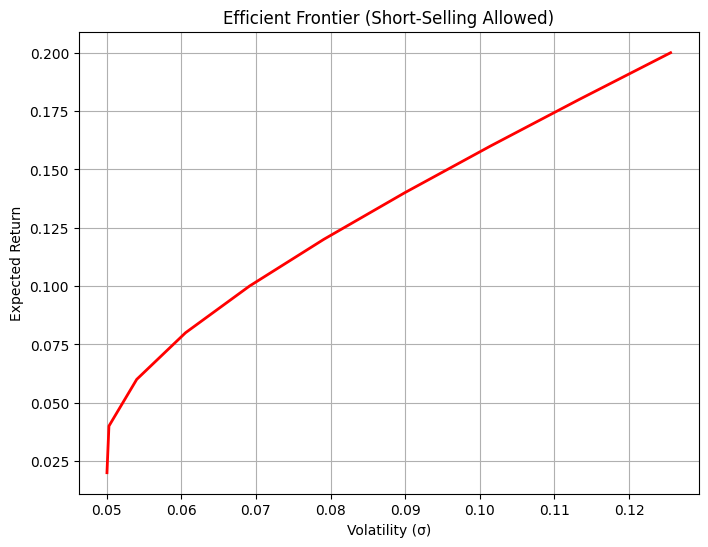

In [247]:
# Efficient Frontier Graph

plt.figure(figsize=(8,6))
plt.plot(portfolio_vols, portfolio_returns, 'r-', lw=2)
plt.title("Efficient Frontier (Short-Selling Allowed)")
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.show()

In [248]:
# weight_matrix gets the weights of each asset for each respective target return

weights_matrix = np.column_stack(weights_list) 

In [249]:
# Creating a dataframe to see the respective weights of each asset for each target return

percent_cols = [f"{r*100:.1f}%" for r in target_returns] # converting target returns to %s

weights_df = pd.DataFrame(
    weights_matrix,
    index = tickers,
    columns = percent_cols
)

weights_df

,2.0%,4.0%,6.0%,8.0%,10.0%,12.0%,14.0%,16.0%,18.0%,20.0%
SPY,0.959868,0.884452,0.809036,0.733620,0.658203,0.582787,0.507371,0.431955,0.356538,0.281122
IJH,-0.008309,0.001546,0.011401,0.021255,0.031110,0.040964,0.050819,0.060674,0.070528,0.080383
IWM,0.081705,0.073198,0.064691,0.056184,0.047677,0.039170,0.030663,0.022156,0.013649,0.005142
EFA,-0.009043,-0.031000,-0.052957,-0.074913,-0.096870,-0.118827,-0.140784,-0.162740,-0.184697,-0.206654
EEM,0.012736,-0.019826,-0.052388,-0.084950,-0.117512,-0.150074,-0.182636,-0.215198,-0.247760,-0.280322
AGG,-0.037368,0.023446,0.084260,0.145074,0.205887,0.266701,0.327515,0.388329,0.449143,0.509956
VNQ,0.071895,0.113396,0.154898,0.196399,0.237900,0.279401,0.320903,0.362404,0.403905,0.445407
DBC,-0.058957,-0.115506,-0.172055,-0.228604,-0.285153,-0.341702,-0.398251,-0.454800,-0.511349,-0.567898
GLD,0.057769,0.165338,0.272906,0.380475,0.488043,0.595612,0.703180,0.810749,0.918317,1.025886
BTC-USD,-0.070298,-0.095045,-0.119792,-0.144539,-0.169286,-0.194033,-0.218780,-0.243527,-0.268275,-0.293022


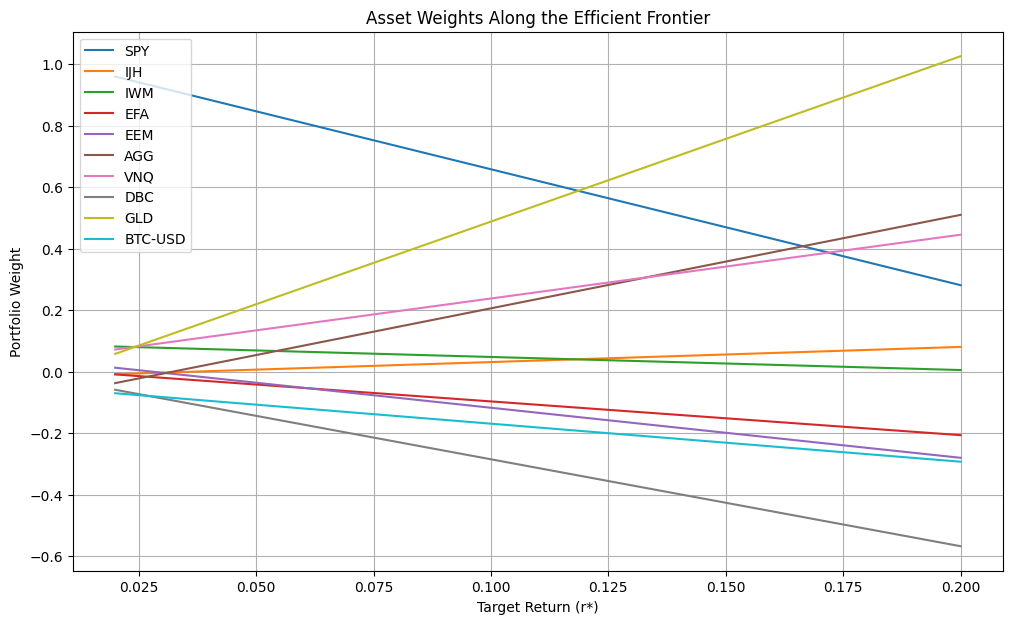

In [250]:
# Visualize Asset 

plt.figure(figsize=(12,7))

for i, ticker in enumerate(tickers):
    plt.plot(target_returns, weights_matrix[i], label=ticker)

plt.title("Asset Weights Along the Efficient Frontier")
plt.xlabel("Target Return (r*)")
plt.ylabel("Portfolio Weight")
plt.legend()
plt.grid(True)
plt.show()


##### Now we want to introduce a long-only constraint (Shorting not allowed. Weights of individual assets have to be above 0)

In [251]:
# Define the long-only optimization function

def min_var_long_only(r_star, mu, sigma):
    n = len(mu)

    w = cp.Variable(n)                              # Unknown vector of decision variables of length n (one for each asset)

    objective = cp.Minimize(cp.quad_form(w, sigma)) # Assigning 'objective' variable with minimization optimization
    constraints = [
        w @ mu == r_star,
        cp.sum(w) == 1,
        w >= 0
    ]

    prob = cp.Problem(objective, constraints)       # Passing objective and constraints to solver
    prob.solve()

    return w.value

In [252]:
# Iterate through r-star

long_only_weights = []
long_only_returns = []
long_only_vols = []

for r_star in target_returns:
    w = min_var_long_only(r_star, mu, sigma)
    long_only_weights.append(w)

    ret = mu @ w                                  # The solver cannot guarantee exact equality and may return the 
                                                  # closest feasible portfolio — so we must compute mu @ w again
    vol = np.sqrt(w.T @ sigma @ w)

    long_only_returns.append(ret)
    long_only_vols.append(vol)

In [253]:
# Create a dataframe with our long-only weights

long_only_weights_matrix = np.column_stack(long_only_weights)

weights_df_long = pd.DataFrame(
    long_only_weights_matrix,
    index=tickers,
    columns=[f"{r*100:.1f}%" for r in target_returns]
)

weights_df_long_rounded = weights_df_long.round(6)

In [254]:
weights_df_long_rounded

,2.0%,4.0%,6.0%,8.0%,10.0%,12.0%,14.0%,16.0%,18.0%,20.0%
SPY,0.978806,0.805874,0.691003,0.576132,0.461262,0.338366,0.213735,0.089104,0.000000,-0.000000
IJH,0.000000,0.007920,0.021157,0.034394,0.047631,0.061407,0.075300,0.089192,0.112250,0.158295
IWM,0.021194,0.062047,0.042521,0.022996,0.003470,0.000000,0.000000,0.000000,0.000000,0.000000
EFA,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EEM,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGG,0.000000,0.057482,0.137287,0.217092,0.296897,0.373313,0.448997,0.524680,0.575389,0.563459
VNQ,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DBC,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GLD,0.000000,0.066678,0.108032,0.149387,0.190741,0.226915,0.261969,0.297023,0.312361,0.278246
BTC-USD,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


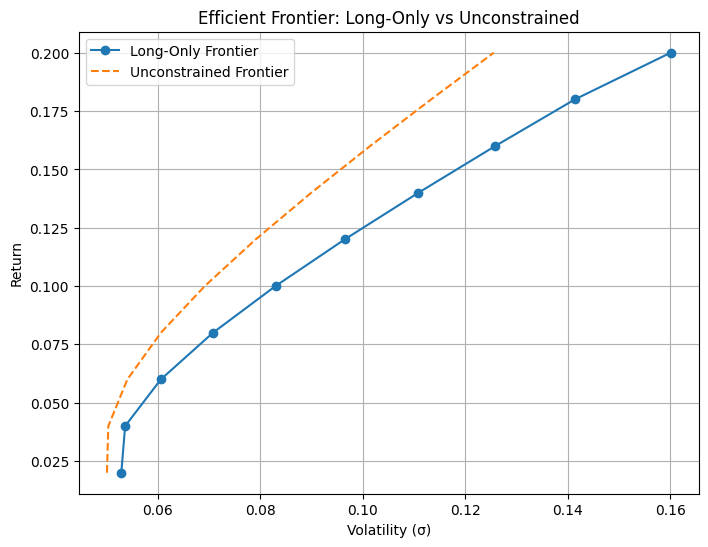

In [255]:
# Visualize Efficient Frontier of Long-Only vs Unconstrained portfolios

plt.figure(figsize=(8,6))
plt.plot(long_only_vols, long_only_returns, 'o-', label="Long-Only Frontier")
plt.plot(portfolio_vols, portfolio_returns, '--', label="Unconstrained Frontier")
plt.xlabel("Volatility (σ)")
plt.ylabel("Return")
plt.title("Efficient Frontier: Long-Only vs Unconstrained")
plt.grid(True)
plt.legend()
plt.show()

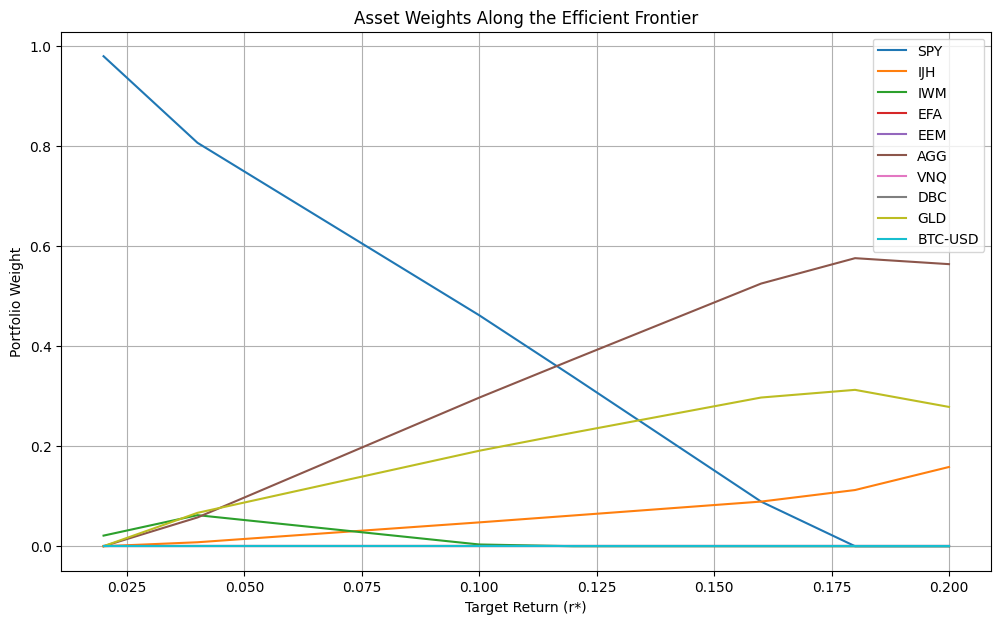

In [258]:
# Visualize Asset 

plt.figure(figsize=(12,7))

for i, ticker in enumerate(tickers):
    plt.plot(target_returns, long_only_weights_matrix[i], label=ticker)

plt.title("Asset Weights Along the Efficient Frontier")
plt.xlabel("Target Return (r*)")
plt.ylabel("Portfolio Weight")
plt.legend()
plt.grid(True)
plt.show()

#### Monte Carlo Simulation To Verify The Model

##### We want to verify that the portfolios for each target returns behave as expected. Variances for lower target returns should correspondingly be lower as well.

##### We use Monte Carlo Simulation to simulate the returns for each asset. We then apply our asset weights for each portfolio for each target return to compare. The results reflect what should be expected from each portfolio if we had invested according to the prescribed asset weights from the beginning of the simulated time period.

In [262]:
# Monte Carlo simulation for unconstrained portfolio first (short-selling allowed)

n_paths = 10000                                     # Number of scenarios
n_years = 10
n_assets, n_portfolios = weights_matrix.shape

np.random.seed(42)                                  # To produce same results every run

# Simulate asset returns across n_paths, n_years, and for each asset using Multivariate normal distribution
# which is characterized by each asset having a mean, a variance, and a covariance between every pair of assets.
sim_asset_returns = np.random.multivariate_normal(  
    mean=mu,                                       
    cov=sigma,
    size=(n_paths, n_years)
)

# Simulate portfolio returns by applying weights matrix to the simulated asset returns
sim_port_returns = sim_asset_returns @ weights_matrix 



In [275]:
# Sample means and volatilities across all paths
mc_mean_returns = sim_port_returns.mean(axis=(0, 1))     
mc_vol_returns  = sim_port_returns.std(axis=(0, 1))      # Volatility = Std Deviation of the combined distribution
                                                         # of returns across all paths (statistically equivalent
                                                         # to the portfolio's volatility)

print("Mean Returns across all paths: ", mc_mean_returns)
print()
print("Sample volatilities across all paths: ", mc_vol_returns)

Mean Returns across all paths:  [0.02009676 0.0401036  0.06011044 0.08011728 0.10012412 0.12013096
 0.1401378  0.16014463 0.18015147 0.20015831]

Sample volatilities across all paths:  [0.05006828 0.05036225 0.05407409 0.06057875 0.06909189 0.07896658
 0.08975456 0.10116406 0.11300699 0.12516038]


In [274]:
# Monte Carlo Table with Target Return, And Corresponding Mean Return & Volatility across all paths

df_mc = pd.DataFrame({
    "Target Return": target_returns,
    "MC Mean Return": mc_mean_returns,
    "MC Volatility": mc_vol_returns         
})

df_mc

,Target Return,MC Mean Return,MC Volatility
0,0.02,0.020097,0.050068
1,0.04,0.040104,0.050362
2,0.06,0.060110,0.054074
3,0.08,0.080117,0.060579
4,0.10,0.100124,0.069092
5,0.12,0.120131,0.078967
6,0.14,0.140138,0.089755
7,0.16,0.160145,0.101164
8,0.18,0.180151,0.113007
9,0.20,0.200158,0.125160


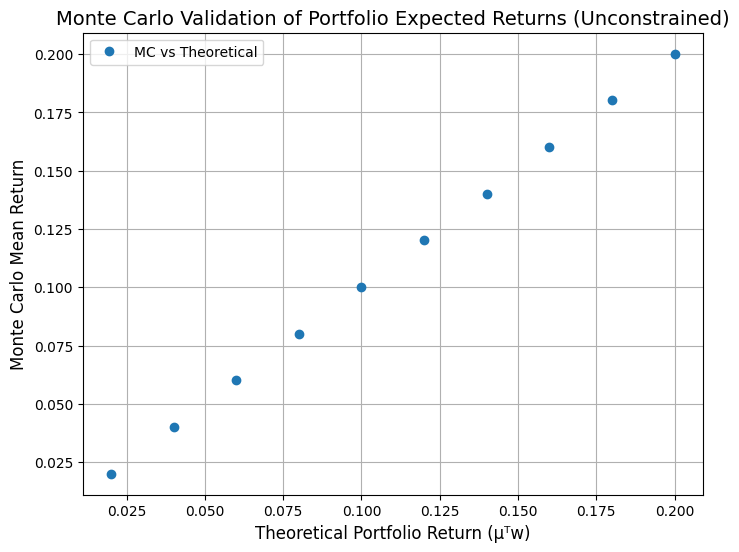

In [277]:
plt.figure(figsize=(8,6))

plt.plot(portfolio_returns, mc_mean_returns, 'o', label="MC vs Theoretical")

plt.xlabel("Theoretical Portfolio Return (μᵀw)", fontsize=12)
plt.ylabel("Monte Carlo Mean Return", fontsize=12)
plt.title("Monte Carlo Validation of Portfolio Expected Returns (Unconstrained)", fontsize=14)

plt.grid(True)
plt.legend()
plt.show()


#### Long-Only Portfolios Monte Carlo Simulation

In [278]:

n_paths = 10000
n_years = 10

# Extract shape of long-only weights matrix
n_assets, n_portfolios = long_only_weights_matrix.shape

np.random.seed(42)   # Ensure reproducibility

# Simulate Asset Returns 
sim_asset_returns_lo = np.random.multivariate_normal(
    mean=mu,
    cov=sigma,
    size=(n_paths, n_years)
)

# Apply Long-Only Weights to Simulated Returns
sim_port_returns_lo = sim_asset_returns_lo @ long_only_weights_matrix


mc_mean_returns_lo = sim_port_returns_lo.mean(axis=(0, 1))
mc_vol_returns_lo  = sim_port_returns_lo.std(axis=(0, 1))

print("Long-Only MC Mean Returns:", mc_mean_returns_lo)
print()
print("Long-Only MC Volatilities:", mc_vol_returns_lo)


df_mc_longonly = pd.DataFrame({
    "Target Return": target_returns,
    "MC Mean Return": mc_mean_returns_lo,
    "MC Volatility": mc_vol_returns_lo
})

df_mc_longonly

Long-Only MC Mean Returns: [0.02023151 0.04022033 0.06026029 0.08030025 0.10034021 0.12036082
 0.14037725 0.16039367 0.18039879 0.20037553]

Long-Only MC Volatilities: [0.05284315 0.05362116 0.06056678 0.0706885  0.08283004 0.0962697
 0.11059567 0.12550574 0.14101378 0.15973738]


,Target Return,MC Mean Return,MC Volatility
0,0.02,0.020232,0.052843
1,0.04,0.040220,0.053621
2,0.06,0.060260,0.060567
3,0.08,0.080300,0.070689
4,0.10,0.100340,0.082830
5,0.12,0.120361,0.096270
6,0.14,0.140377,0.110596
7,0.16,0.160394,0.125506
8,0.18,0.180399,0.141014
9,0.20,0.200376,0.159737


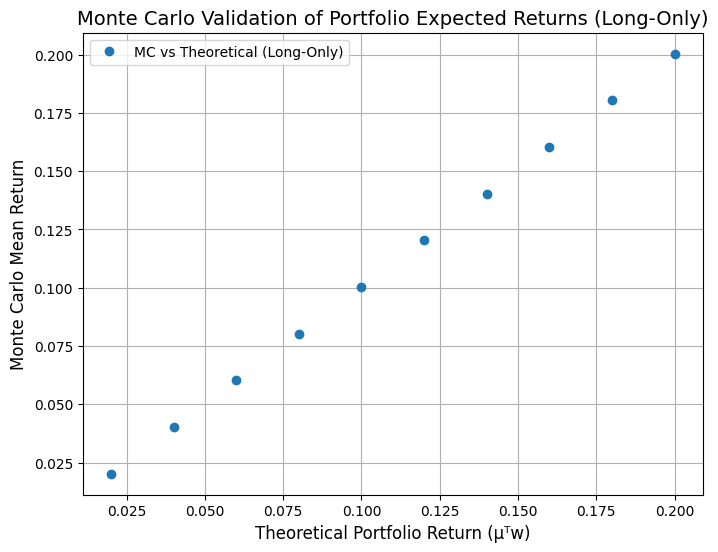

In [283]:
plt.figure(figsize=(8,6))

plt.plot(long_only_returns, mc_mean_returns_lo, 'o',
         label="MC vs Theoretical (Long-Only)")

plt.xlabel("Theoretical Portfolio Return (μᵀw)", fontsize=12)
plt.ylabel("Monte Carlo Mean Return", fontsize=12)
plt.title("Monte Carlo Validation of Portfolio Expected Returns (Long-Only)", fontsize=14)

plt.grid(True)
plt.legend()
plt.show()

##### "The output from an optimization program may apply only to the period from which the data are drawn and not to a future period. Even if current results apply to the future, they might not be applicable for long." - CFA Curriculum